In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import RobustScaler
from collections import deque



# Visualization
import matplotlib.pyplot as plt

/Users/varunchowdary/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/varunchowdary/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from yahoo_fin import stock_info as yf


In [6]:
# Modelling
from keras.models import Sequential


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
def getData(stock, year_back, interval):
    
    STOCK = stock
    now = datetime.now() # Current date and time
    DATE_NOW = now.strftime('%Y-%m-%d') # Extract the today's date as a string 
    STARTING_DATE = (now - relativedelta(years=year_back)).strftime('%Y-%m-%d') # Extract the starting date as a string
    raw_data = yf.get_data(STOCK, start_date = STARTING_DATE, end_date = DATE_NOW, interval = interval)

    return raw_data


def Visualize_Data(df, Stock, interval, figsize = (20,9)):

  plt.style.use(style='ggplot')
  plt.figure(figsize=figsize)
  plt.plot(df['close'])
  plt.xlabel('Date')
  plt.ylabel('Price in $')
  plt.legend([f'Price per {Stock} share'])
  plt.title(f'Share price of {Stock}')
  plt.show()

In [ ]:
def prepData(data, days):
    df = data.copy()
    df['future'] = df['scaled_close'].shift(-days)#using dropna to drop all days that have nans, which I should have realzied when Im working on my FX project
    last_sequence = np.array(df[['scaled_close']].tail(days))
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=NUMBER_of_STEPS_BACK)

    #using the data just get the scaled close and then the future values into one list 
    for entry, target in zip(df[['scaled_close','date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == NUMBER_of_STEPS_BACK:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:1] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # build X and Y training set
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert X and Y to numpy arrays for compatibility
    X = np.array(X)
    Y = np.array(Y)

    return last_sequence, X, Y

In [ ]:
def model_train(x_train, y_train, NUMBER_of_STEPS_BACK, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS):
    model = Sequential() #one input in
    model.add(LSTM(UNITS, return_sequences=True, input_shape=(NUMBER_of_STEPS_BACK, 1)))
    model.add(Dropout(DROPOUT))
    model.add(LSTM(UNITS, return_sequences=False))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1))# one output

    model.compile(loss=LOSS, optimizer=OPTIMIZER)

    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    model.summary()

    return model



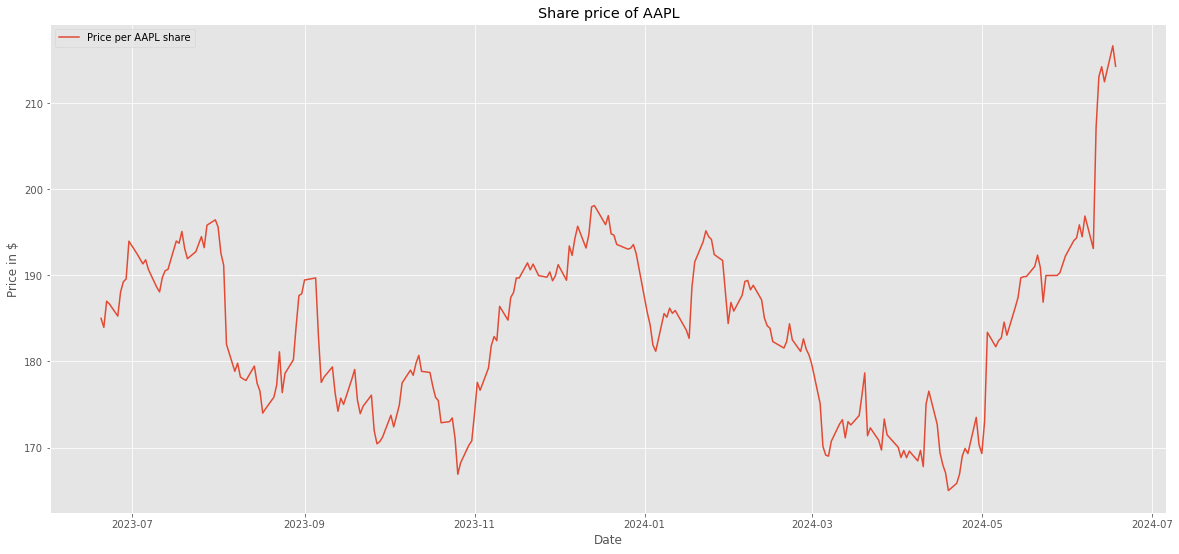

In [5]:
STOCK = 'AAPL' # Specify the ticker symbol of the share
YEAR_BACK = 1 # Number of years of data back from today for extraction
INTERVAL = '1d' # The frequency of the extracted data. 1d: daily, 4h: 4 hourly

# Visualize Data
raw_price_df = getData(stock = STOCK, year_back = YEAR_BACK, interval = INTERVAL )
Visualize_Data(raw_price_df, Stock = STOCK, interval = INTERVAL)

# Pre-process Data
raw_price_df = raw_price_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
raw_price_df['date'] = raw_price_df.index
scaler = RobustScaler()
raw_price_df['scaled_close'] = scaler.fit_transform(np.expand_dims(raw_price_df['close'].values, axis=1))

#Set Parameters/Hyperparameters
NUMBER_of_STEPS_BACK = 30 # Number of days back that the model will be trained for
PREDICTION_STEPS = [1] # Number of days that the model will predict. To predict the next three days, modify it as follows: [1,2,3]
BATCH_SIZE = 16 # Number of training samples that will be passed to the network in one epoch
DROPOUT = 0.25 # Probability to exclude the input and recurrent connections to improve performance by regularization (25%)
UNITS = 60 # Number of neurons connected to the layer
EPOCHS = 10 # Number of times that the learning algorithm will work through the entire training set 
LOSS='mean_squared_error' # Methodology to measure the inaccuracy
OPTIMIZER='adam' # Optimizer used to iterate to better states


In [ ]:
# Make Prediction
predictions = []

for step in PREDICTION_STEPS:
  last_sequence, x_train, y_train = prepData(raw_price_df, step)
  x_train = x_train[:, :, :1].astype(np.float32)

  model = model_train(x_train, y_train, NUMBER_of_STEPS_BACK, BATCH_SIZE, UNITS, EPOCHS, DROPOUT, OPTIMIZER, LOSS)
  
  last_sequence = last_sequence[-NUMBER_of_STEPS_BACK:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

In [ ]:
if len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} share price prediction for the next day(s) {predictions_str}'
  print(message)